# **Importing Libraries**

In [ ]:
import pandas as pd
import io
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!pip install wordcloud

In [ ]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#from word_cloud.word_cloud_generator import WordCloud
from IPython.core.display import HTML
from nltk.corpus import reuters
import nltk

In [ ]:
!pip install geopandas

     |████████████████████████████████| 962kB 2.8MB/s 
     |████████████████████████████████| 10.9MB 14.3MB/s 
     |████████████████████████████████| 14.7MB 254kB/s 


In [ ]:
from sklearn import preprocessing, metrics
import statsmodels.api as sm
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
%matplotlib inline

# **Fetching data**

In [ ]:
#link to dataset : https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data

from google.colab import files
uploaded = files.upload()

Saving AB_NYC_2019.csv to AB_NYC_2019.csv


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['AB_NYC_2019.csv'])) # Dataset is now stored in a Pandas Dataframe named df
df.head() #printing the intial rows of dataframe

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,10/19/2018,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,5/21/2019,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,7/5/2019,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,11/19/2018,0.10,1,0


# **Data Exploration**

In [ ]:
#Understanding data types
df.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

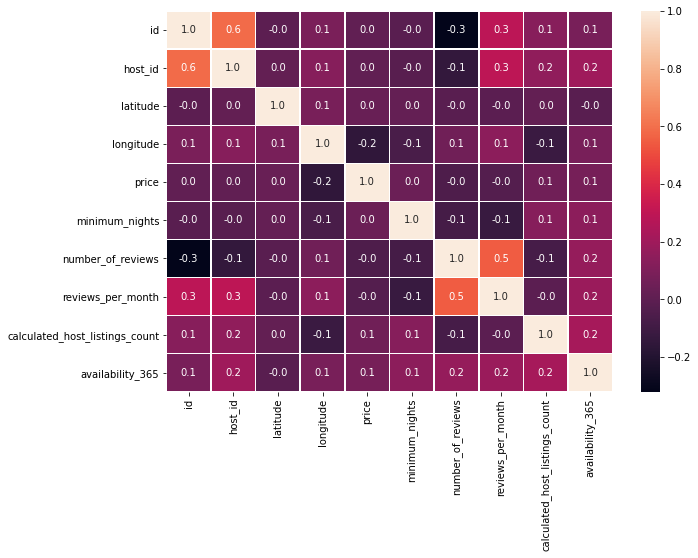

In [ ]:
#Finding the correlation between various attributes

#correlation map
plt.subplots(figsize=(10, 7))

#Annotate each cell with the numeric value using integer formatting
#fmt : String formatting code to use when adding annotations, decides number of decimal places 
#cmap : Colormap
sns.heatmap(df.corr(method='pearson'), annot=True, linewidths=.5, fmt= '.1f'); 

The correlation table shows that there is a similar relationship between price and all other features. So we won't be discarding any feature at this moment


**Understanding the realtionship between room Type vs Price vs Neighbourhood Group.**

Text(0.5, 1.0, 'Room Type vs Price vs Neighbourhood Group')

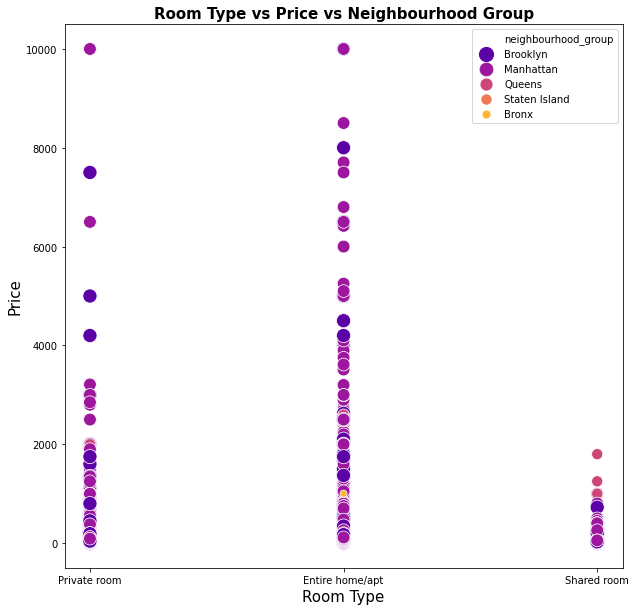

In [ ]:
#Setting the plot size
plt.figure(figsize=(10,10))

#Plotting the scatterplot 
# On x axis we have room types, on y axis we have price 
# The color and size of plot depends on neighbourhood_group
sns.scatterplot(x="room_type", y="price",
            hue="neighbourhood_group", size="neighbourhood_group",
            sizes=(50, 200), palette="plasma", data=df)

# Label on x axis
plt.xlabel("Room Type", size=15)

# label on y axis
plt.ylabel("Price", size=15)

#title of the plot
plt.title("Room Type vs Price vs Neighbourhood Group",size=15, weight='bold')

**Analysing outliers in price attribute**

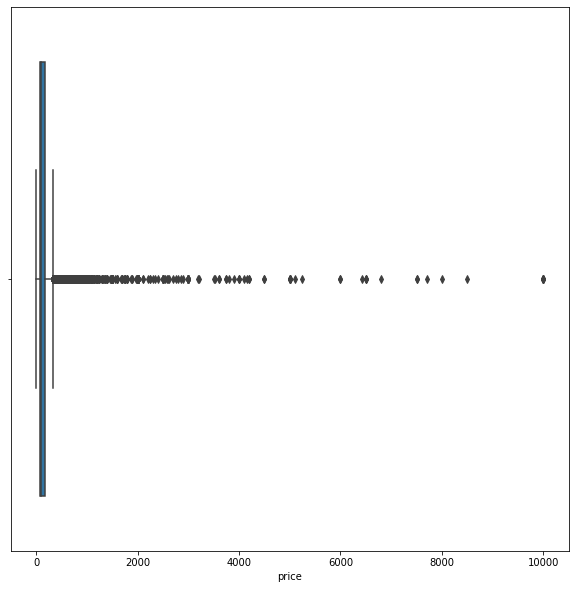

In [ ]:
plt.figure(figsize=(10,10)) #Setting the plot size
sns.boxplot(data= df, x=df["price"]) #Plotting the price column values

# **DATA PREPROCESSING**

In [ ]:
#Finding number of columns with missing values

# Printing total number of null values in each column
print(df.isnull().sum())

# Printing total number of columns with missing values
print("Total number of columns with missing values: ", df.isnull().any(axis=0).sum())

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64
Total number of columns with missing values:  4


In [ ]:
# Replacing the missing values.
# We aren't calculating filling missing cells with mode or mean for categorical and numerical attributes  
# Because are it will result in misinterpretation, example: host with max listings may be changed

df.fillna({'reviews_per_month':0}, inplace=True)
df.fillna({'name':"NoName"}, inplace=True)
df.fillna({'host_name':"NoName"}, inplace=True)


In [ ]:
#converting the 'last_review' column to datetime format 
df['last_review']= pd.to_datetime(df['last_review']) 

In [ ]:
# Replacing Null values of last_review attribute using ffill method.
# ffill stands for ‘forward fill’ and will propagate last valid observation forward inplace of Null values
df.last_review.fillna(method="ffill", inplace=True)

**Imputing Price Outliers** 

In [ ]:
df["price"].describe()
# We can see that max price of a listing is 10000 and min is 0. The average of the price is 152

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

In [ ]:
#checking the number of entries in our dataset
#we have 48895 listing in our data
df.shape

(48895, 16)

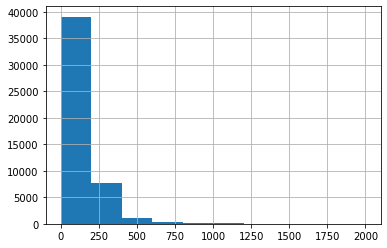

In [ ]:
#Plotting the number of listings with price less than $2000
df["price"][df["price"]<2000].hist()

#We see that majority of listings have a price between $0 and $750, rest are negligible

In [ ]:
# To be sure that we arent imputing major chunk for our data lets count the listings with price $1000 above 
df["price"][df["price"]>1000].shape

(239,)

239 listings have price above $1000. These listings are skewing our data a lot, we will treat them as outliers and drop them.

In [ ]:
df=df[df["price"]<1000]

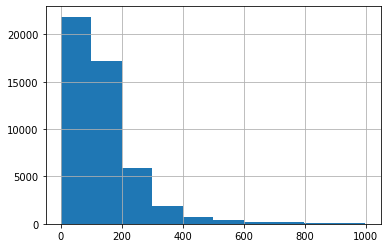

In [ ]:
df["price"][df["price"]<1000].hist()

# **DATA INSIGHTS**


**5 Neighbourhood-Groups/ Borough with maximums listings**

In [ ]:
#Specifying the color schemes
colors = ['#682A7E', '#9932CC', '#C12267','#CD853F','#FFA07A']

#Label stores the name of neighbourhood_group
labels = df.neighbourhood_group.value_counts().index
#Values store the count of listings each neighbour hood has
values = df.neighbourhood_group.value_counts().values

# Use pull to drag out a piece from pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values,pull=[0, 0, 0.5, 0,0] )])
fig.update_traces(marker=dict(colors =colors , line=dict(color='#000000', width=2)))

#displays the plot
fig.show()

 **We can see that Manhattan and Brooklyn counts for 85% of all hostings.
Lets visualize our finding on a map**

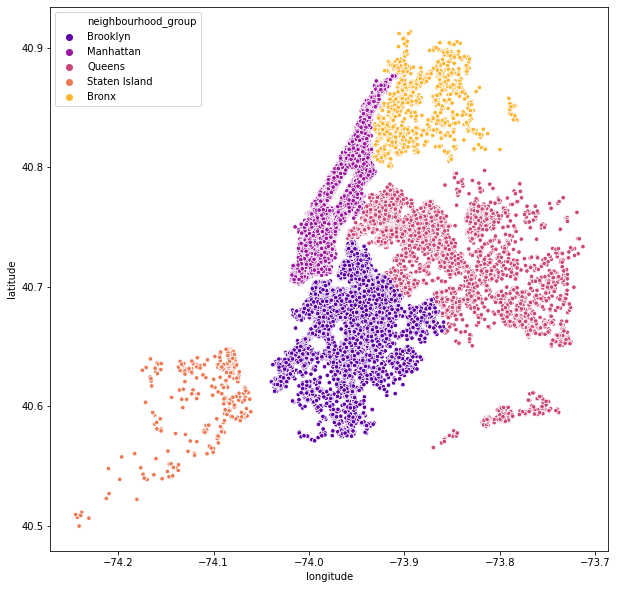

In [ ]:
# creates the figure of size 10 widht and 10 height
plt.figure(figsize=(10,10))
# simple scatterplot of different neighbourhood_groups in nyc
# later we will plot these stuff on actual nyc map
sns.scatterplot(x='longitude', y='latitude', hue='neighbourhood_group',s=20, data=df, palette="plasma")

# we can see different borough's of nyc

**Average price of listings in Neighbourhood-Groups/ Borough**

Text(0.5, 1.0, 'Density and distribution of prices for each neighberhood_group')

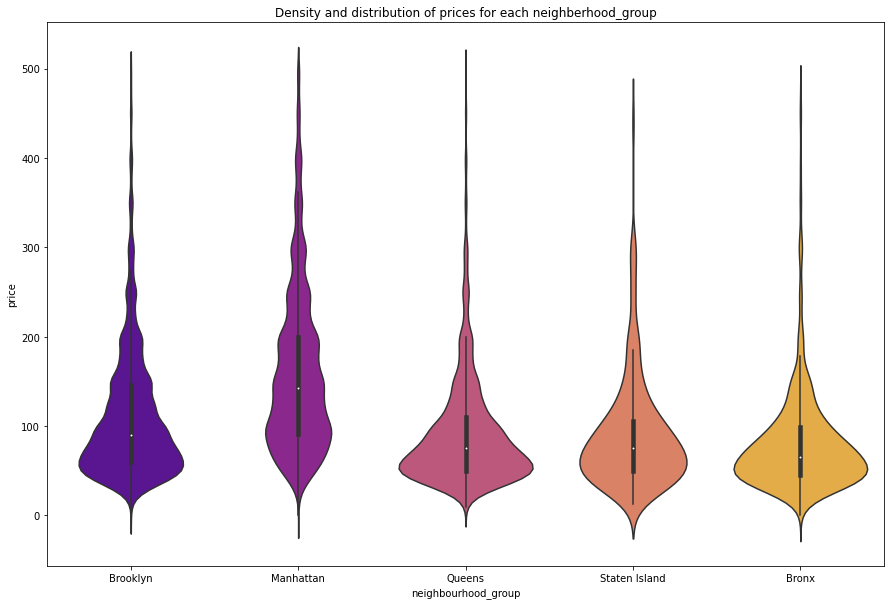

In [ ]:
#Our data has maximum listings in price range of uptil $500, therefore for the sake of a better visualization we will subset our data

#creating a subset of dataframe where listings have price less than 500
df_sub=df[df.price < 500]

#Resize the shape
plt.figure(figsize=(15,10))

#using violinplot to showcase density and distribtuion of prices 
viz=sns.violinplot(data=df_sub, x='neighbourhood_group', y='price', palette="plasma")
#title of plot
viz.set_title('Density and distribution of prices for each neighberhood_group')

From the plots we can see that Manhattan has the highest range of prices for the listings with $150 

price as average, followed by Brooklyn with $90 per night. Queens and Staten Island appear to have very similar distributions, Bronx is the cheapest of them 

**Most popular types of Room which are been listed**

In [ ]:
#Specifying the color schemes
colors = ['#682A7E', '#C12267', '#d6604d']

#Label stores the names of room type
labels = df.room_type.value_counts().index
#Values store the count of listings of each room type
values = df.room_type.value_counts().values

#Use `hole` to create a donut-like pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20,marker=dict(colors = colors, line=dict(color='#000000', width=2)))

#Displays the plot
fig.show()
#Aprroximately 97.6% of the listings are for Entire home/Apt and Private room combined

**Listings classified first by neighbourhood_group and second by by Room type**

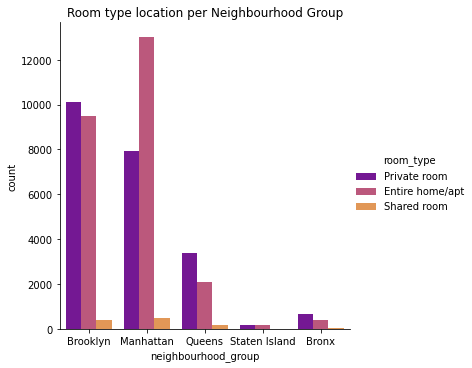

In [ ]:
# Plots the graph
# On x axis we have different neighborhood groups, on y axis is the number of listings
# Size of each bar depends on room type attribute
sns.catplot(x='neighbourhood_group', kind="count", hue="room_type", data=df, palette="plasma");

# Title of the graph
plt.title('Room type location per Neighbourhood Group')

#Plotting the graph
plt.ioff()

### **High frequency words in name attribute**

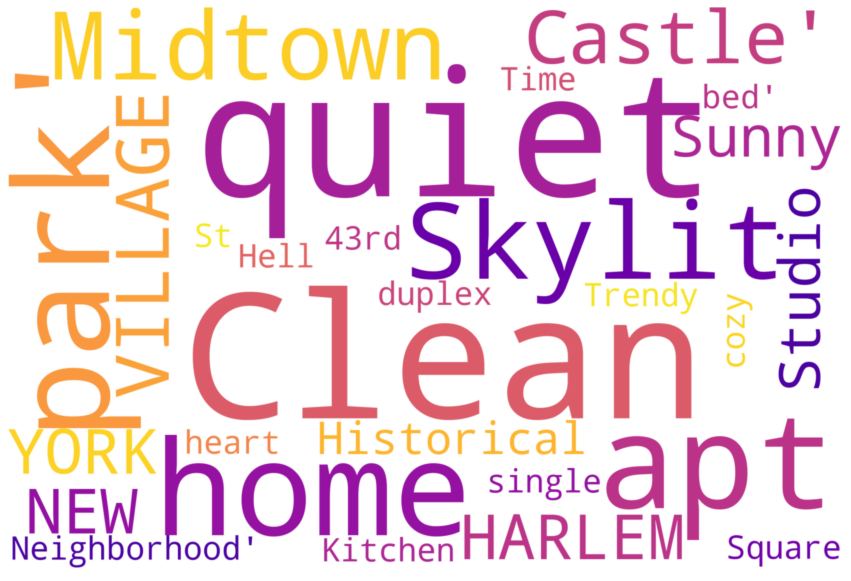

In [ ]:
# Store the attribute whose word cloud we have to create
text = df['name'].values 

# Create and generate a word cloud image:
wordcloud = WordCloud(colormap="plasma",width=1920, height=1300,max_font_size=400, max_words=300, background_color="white").generate(str(text))

#Resize the plot
plt.figure(figsize=(15,15))

# Not displaying x and y axis
plt.axis("off")

# Display the generated image:
plt.imshow(wordcloud, interpolation="gaussian")
plt.show()

**Top 5 Neighbourhood with max and min listings**

In [ ]:
#Counting the number of listings in each neighbourhood
df['neighbourhood'].value_counts()

#We can see that Williamsburg has max number of listings in NYC

Williamsburg          3908
Bedford-Stuyvesant    3701
Harlem                2650
Bushwick              2463
Hell's Kitchen        1948
                      ... 
Rossville                1
Willowbrook              1
Woodrow                  1
New Dorp                 1
Richmondtown             1
Name: neighbourhood, Length: 221, dtype: int64

# **Lasso Regression: Supervised Machine Learning Algorithm**

In [ ]:
#Storing original dataframe df in a new dataframe called dataset
dataset=df

In [ ]:
# We use $250 as threshold price and subset our new dataframe
dataset=dataset[dataset["price"]<250]

In [ ]:
# Displaying intial rows of our dataframe
dataset.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,2019-05-21,0.00,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [ ]:
# After analysis I have decided to drop columns which are redundant for our prediction
dataset.drop(["id","host_name","name",'last_review',"latitude",'longitude','host_id'], axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# Converting categorical variables which will be useful in our prediction into dummy/indicator variables.
dataset_onehot2 = pd.get_dummies(dataset, columns=['neighbourhood_group',"neighbourhood","room_type"], prefix = ['ng',"nh","rt"],drop_first=True)

In [ ]:
# Checking the size of dummy coded dataframe
dataset_onehot2.shape

(42669, 230)

**Splitting into training and testing data**

In [ ]:
# Storing Independent variables irrespective of price attribute in variable X
X= dataset_onehot2.loc[:, dataset_onehot2.columns != 'price']

# Storing dependent variable price in variable Y
Y = dataset_onehot2["price"]

# Allocating 80% of the data to the training set while 20% of the data to test set
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [ ]:
# importing Lasso Regression class to train data

reg = Lasso(alpha=0.01)
reg.fit(x_train, y_train) 

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
# Calculating R squared value
reg.score(x_train, y_train)

0.5555331063927165

In [ ]:
# making predictions on the test data
y_pred= reg.predict(x_test)

# Printing Root Mean Squared Error
print(np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

35.41734687758755


In [ ]:
# We can see that some parameters have zero coefficients.
reg.coef_

array([-1.74262135e-01, -1.11855439e-02, -3.56749362e-01,  4.36473891e-02,
        4.29270645e-02,  1.15632265e+01,  4.87171476e+01,  5.54501162e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  1.82712459e+00,
        7.24018705e+00, -0.00000000e+00,  0.00000000e+00, -1.06743166e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.84686608e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -9.35126851e+00, -0.00000000e+00,  2.04913205e+01,
       -1.09367819e+01,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -3.41331178e+00,  2.95526534e+01, -3.70432802e+00, -0.00000000e+00,
       -1.86749897e+00,  0.00000000e+00, -5.95988041e+00,  2.45105014e+01,
       -0.00000000e+00,  0.00000000e+00,  1.25715664e+01, -6.27950423e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  1.74594438e+01,  0.00000000e+00,  2.14169869e+01,
       -0.00000000e+00,  

In [ ]:
# Creating dataframe named Coeff with columnn "Variable","Coefficients"
Coeff = pd.DataFrame(columns=["Variable","Coefficients"])
# Storing the labels in variable
Coeff["Variable"]=x_train.columns
# Storing coefficients in variable 'Coefficient'
Coeff["Coefficients"]=reg.coef_
# Sorting the Coefficient values in descending order 
Coeff.sort_values("Coefficients", ascending = False)

,Variable,Coefficients
6,ng_Manhattan,48.717148
61,nh_DUMBO,32.327024
211,nh_Vinegar Hill,31.184193
33,nh_Brooklyn Heights,29.552653
65,nh_Downtown Brooklyn,24.908605
...,...,...
101,nh_Harlem,-26.636620
213,nh_Washington Heights,-38.483617
110,nh_Inwood,-39.714636
227,rt_Private room,-60.537732


In [ ]:
# Storing Actual vs Predicted values in df_pred dataframe

df_pred = pd.DataFrame({'Actual':(y_test), 'Predicted': (y_pred)})

# Printing top 10 rows of df_pred dataframe
df_pred.head(10)

,Actual,Predicted
34355,46,74.333403
393,165,146.120201
4772,88,120.994670
47742,80,156.840845
46592,90,72.948666
9716,200,144.941798
15528,159,112.509795
7124,195,167.070439
26291,200,146.895938
17212,60,59.897246


In [ ]:
# Created a new dataframe named df_pred_plot and storing top 30 rows of df_pred dataframe
df_pred_plot=df_pred.head(30)

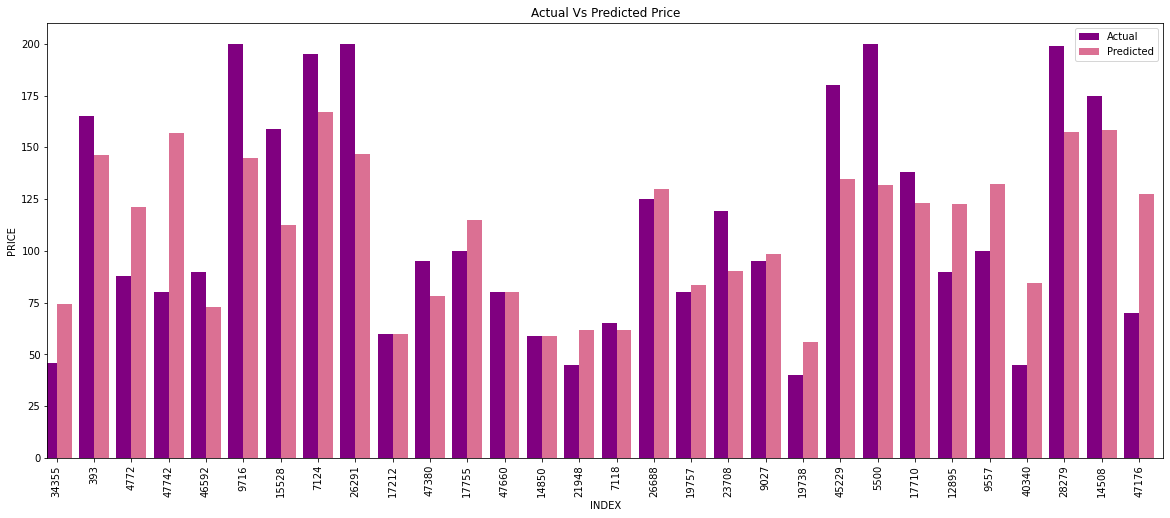

In [ ]:
# Resize the plot
fig = plt.figure(figsize=(20,8)) 

# Create matplotlib axis
ax = fig.add_subplot(111) 
# Setting the width of axis 
width = 0.4

# Displaying the title for the plot
plt.title('Actual Vs Predicted Price')

# Plotting the side by side bars for Actual and Predicted values
df_pred_plot.Actual.plot(kind='bar', color='Purple', ax=ax, width=width, position=1)
df_pred_plot.Predicted.plot(kind='bar', color='#DB7093', ax=ax, width=width, position=0)

# Defining legend on the plot
plt.legend() 

#Setting labels on x & y axis
ax.set_ylabel('PRICE')
ax.set_xlabel('INDEX')

# Display the side by side plot
plt.show()




# **K Means: Unsupervised Machine Learning Algorithm**

In [ ]:
# Storing all numerical features from above dataframe using iloc function in variable x

x = df.iloc[:, [6,7,9,10,11,13,14,15]].values 
x

array([[ 4.064749e+01, -7.397237e+01,  1.490000e+02, ...,  2.100000e-01,
         6.000000e+00,  3.650000e+02],
       [ 4.075362e+01, -7.398377e+01,  2.250000e+02, ...,  3.800000e-01,
         2.000000e+00,  3.550000e+02],
       [ 4.080902e+01, -7.394190e+01,  1.500000e+02, ...,  0.000000e+00,
         1.000000e+00,  3.650000e+02],
       ...,
       [ 4.081475e+01, -7.394867e+01,  1.150000e+02, ...,  0.000000e+00,
         1.000000e+00,  2.700000e+01],
       [ 4.075751e+01, -7.399112e+01,  5.500000e+01, ...,  0.000000e+00,
         6.000000e+00,  2.000000e+00],
       [ 4.076404e+01, -7.398933e+01,  9.000000e+01, ...,  0.000000e+00,
         1.000000e+00,  2.300000e+01]])

In [ ]:
# Using Elbow method, we find the optimal number of clusters in a dataset.
# We will calculate optimum value of k

# Created empty list named Error
Error =[]

# n_clusters stores the number of clusters to form
# fit method on kmeans clusters the data 
# inertia_: Sum of squared distances of samples to their closest cluster center
for i in range(1, 11):
   kmeans = KMeans(n_clusters = i).fit(x)
   kmeans.fit(x)
   Error.append(kmeans.inertia_)


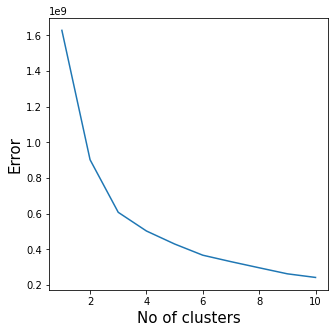

In [ ]:
# Plotting the Elbow graph
plt.figure(figsize=(5,5))

plt.plot(range(1, 11), Error)

# Setting labels on x & y axis
plt.xlabel('No of clusters', fontsize = 15)
plt.ylabel('Error', fontsize = 15)

# Displaying the plot
plt.show()

**As you can see, the optimal value of k is between 2 and 4, as the elbow-like shape is formed at k=3 so we are implementing k-means using k=3**

In [ ]:
#Storing original df dataframe in df_k_mean dataframe
df_kmean= df

In [ ]:
# Setting the DataFrame index using neighbourhood_group column
df_kmean=  df_kmean.set_index('neighbourhood_group')

In [ ]:
# Printing the datframe
df_kmean.head(5)

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
neighbourhood_group,,,,,,,,,,,,,,,
Brooklyn,2539,Clean & quiet apt home by the park,2787,John,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
Manhattan,2595,Skylit Midtown Castle,2845,Jennifer,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
Manhattan,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Harlem,40.80902,-73.94190,Private room,150,3,0,2019-05-21,0.00,1,365
Brooklyn,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
Manhattan,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


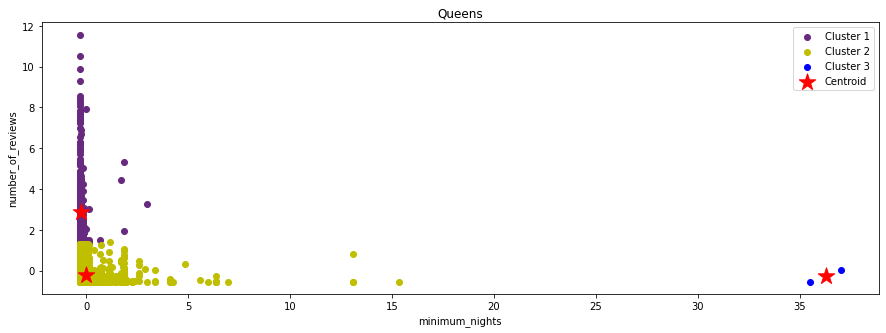

In [ ]:
# In a new dataframe filtering rows based on neighbourhood_group='Queens', then choosing two columns of which we want to do clustering
df_Queens = pd.DataFrame(df_kmean.loc["Queens", ["minimum_nights","number_of_reviews"]])

# Standardizing features by removing the mean and scaling to unit variance
std_Queens = StandardScaler().fit_transform(df_Queens)

# n_clusters stores the number of clusters to form
kmeans_Queens = KMeans(n_clusters=3, max_iter=100)
# fit method on kmeans clusters the data 
kmeans_Queens.fit(std_Queens)
# Coordinates of cluster centers are stored in centroids_Queens
centroids_Queens = kmeans_Queens.cluster_centers_

# Resize The figure
fig, ax = plt.subplots(figsize=(15, 200))
# plotting the 3 clusters
plt.scatter(std_Queens[kmeans_Queens.labels_ == 0, 0], std_Queens[kmeans_Queens.labels_ == 0,1], c ='#682A7E', label="Cluster 1")
plt.scatter(std_Queens[kmeans_Queens.labels_ == 1, 0], std_Queens[kmeans_Queens.labels_ == 1,1], c ='y', label="Cluster 2")
plt.scatter(std_Queens[kmeans_Queens.labels_ == 2, 0], std_Queens[kmeans_Queens.labels_ == 2,1], c ='b', label="Cluster 3")

# Plotting the centroids
plt.scatter(centroids_Queens[:, 0], centroids_Queens[:, 1], marker ='*', s=300, c = 'r', label='Centroid')

# Plotting the legend
plt.legend()

# Stating label on x axis
plt.xlabel('minimum_nights')
# Stating label on y axis
plt.ylabel('number_of_reviews')
# Stating the title of plot
plt.title('Queens')
ax.set_aspect('equal')

We can see as the number of minimum nights increases the reviews received by a listing decreases

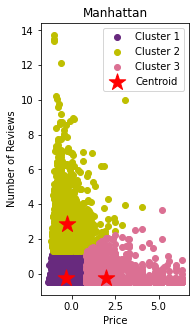

In [ ]:
# In a new dataframe filtering rows based on neighbourhood_group='Manhattan', then choosing two columns of which we want to do clustering
df_Manhat = pd.DataFrame(df_kmean.loc["Manhattan", ["price","number_of_reviews"]])

# Standardizing features by removing the mean and scaling to unit variance
std_Manhat = StandardScaler().fit_transform(df_Manhat)

# n_clusters stores the number of clusters to form
kmeans_Manhat = KMeans(n_clusters=3, max_iter=100)
# fit method on kmeans clusters the data 
kmeans_Manhat.fit(std_Manhat)
# Coordinates of cluster centers are stored in centroids_Queens
centroids_Manhat = kmeans_Manhat.cluster_centers_

# Resize The figure
fig, ax = plt.subplots(figsize=(15, 5))
# plotting the 3 clusters
plt.scatter(std_Manhat[kmeans_Manhat.labels_ == 0, 0], std_Manhat[kmeans_Manhat.labels_ == 0,1], c ='#682A7E', label="Cluster 1")
plt.scatter(std_Manhat[kmeans_Manhat.labels_ == 1, 0], std_Manhat[kmeans_Manhat.labels_ == 1,1], c ='y', label="Cluster 2")
plt.scatter(std_Manhat[kmeans_Manhat.labels_ == 2, 0], std_Manhat[kmeans_Manhat.labels_ == 2,1], c ='#DB7093', label="Cluster 3")

# Plotting the centroids
plt.scatter(centroids_Manhat[:, 0], centroids_Manhat[:, 1], marker ='*', s=300, c = 'r', label='Centroid')

# Plotting the legend
plt.legend()

# Stating label on x axis
plt.xlabel('Price')
# Stating label on y axis
plt.ylabel('Number of Reviews')
# Stating the title of plot
plt.title('Manhattan')
ax.set_aspect('equal')